In [113]:

import pandas as pd
from scipy.stats import entropy
import queue
import numpy as np
import gensim
from scipy.spatial.distance import euclidean
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from nltk import tokenize
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import euclidean_distances
from sklearn import manifold

from source.Topic.Utils import *
from source.Topic.Model import *
import re

In [7]:
#meta = pd.read_csv("metadata.csv")
#meta = pd.read_csv("demo_text_chunk_0.csv", sep=";")

In [2]:
meta = pd.read_csv("kaffee_reviews.csv")
meta.drop(columns=["index"], inplace=True)

In [9]:
meta.head()

,brand,rating,review
0,GEPA Kaffee,5,Wenn ich Bohnenkaffee trinke (auf Arbeit trink...
1,GEPA Kaffee,5,Für mich ist dieser Kaffee ideal. Die Grundvor...
2,GEPA Kaffee,5,Ich persönlich bin insbesondere von dem Geschm...
3,GEPA Kaffee,5,ganz abgesehen vom geschmack legt gepa inzwisc...
4,GEPA Kaffee,5,Seit Jahren kaufe ich am liebsten den Kaffee u...


In [ ]:
documents = meta.iloc[:, 0]
documents=documents.reset_index()
documents.drop("index", inplace = True, axis = 1)

##create pandas data frame with all abstracts, use as input corpus
documents["index"] = documents.index.values
documents.head(3)

In [3]:
method = "BERT_AE" # "LDA_BERT"
samp_size = len(meta.review)
ntopic = 10

rws = meta.review
#rws = pd.Series(sentences)
sentences, token_lists, idx_in = preprocess(rws, samp_size=samp_size)
# Define the topic model object
# tm = Topic_Model(k = 10), method = TFIDF)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


In [4]:
tm = Topic_Model(k=ntopic, method=method)
# Fit the topic model by chosen method
tm.fit(sentences, token_lists)
# Evaluate using metrics
#with open("/kaggle/working/{}.file".format(tm.id), "wb") as f:
#    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

Clustering embeddings ...
Getting vector representations for BERT ...
Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!


In [ ]:
print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
print('Silhouette Score:', get_silhouette(tm))
# visualize and save img

Calculating UMAP projection ...
Calculating UMAP projection. Done!
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!
Getting wordcloud for topic 4 ...
Getting wordcloud for topic 4. Done!
Getting wordcloud for topic 5 ...
Getting wordcloud for topic 5. Done!
Getting wordcloud for topic 6 ...
Getting wordcloud for topic 6. Done!
Getting wordcloud for topic 7 ...
Getting wordcloud for topic 7. Done!
Getting wordcloud for topic 8 ...
Getting wordcloud for topic 8. Done!
Getting wordcloud for topic 9 ...
Getting wordcloud for topic 9. Done!


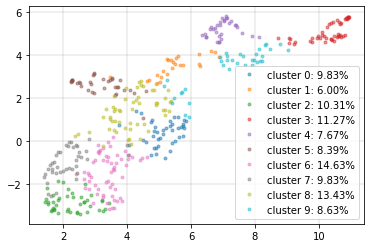

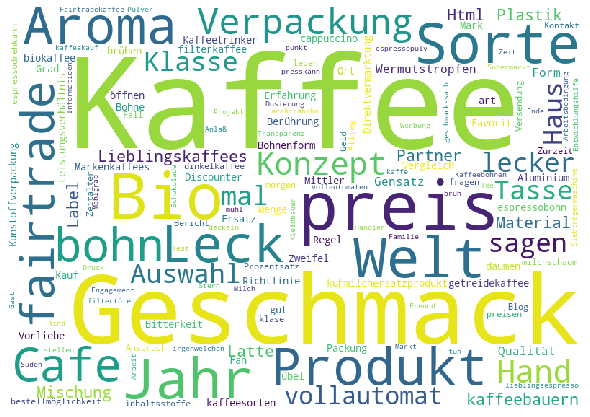

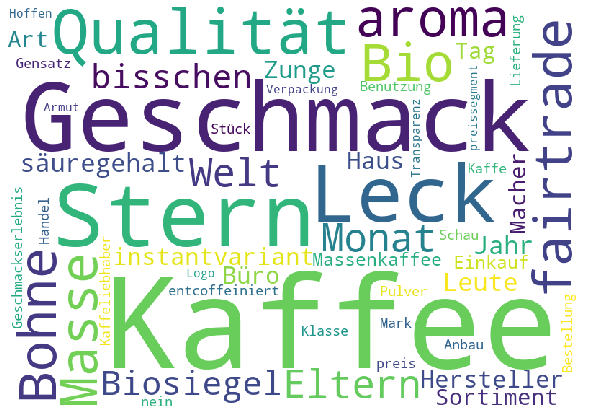

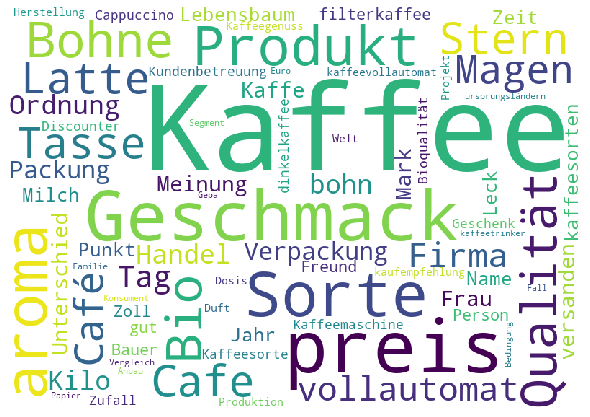

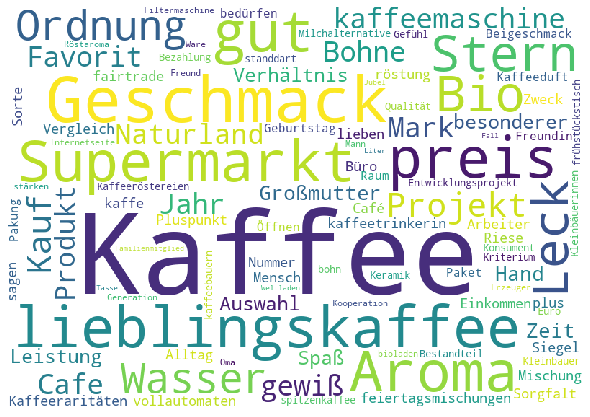

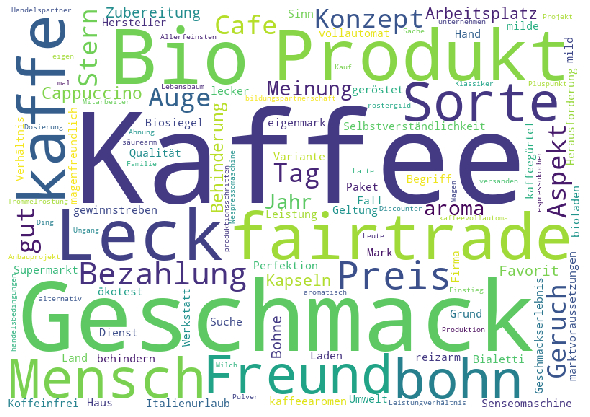

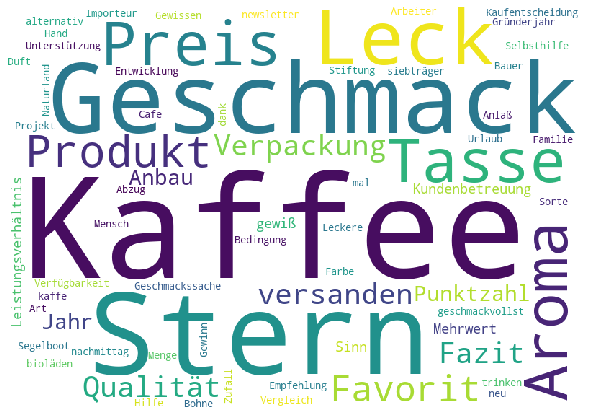

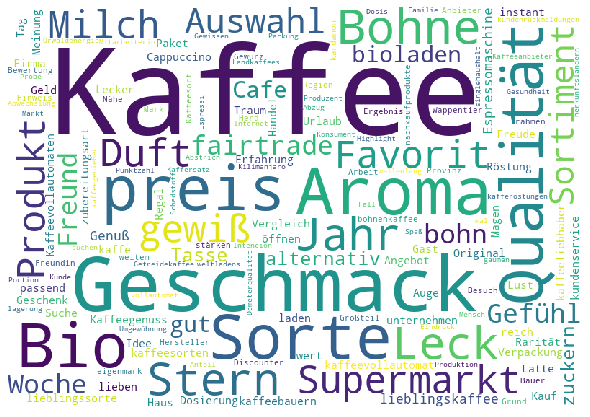

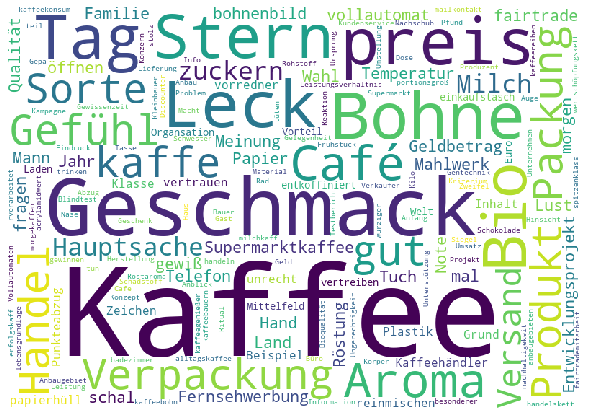

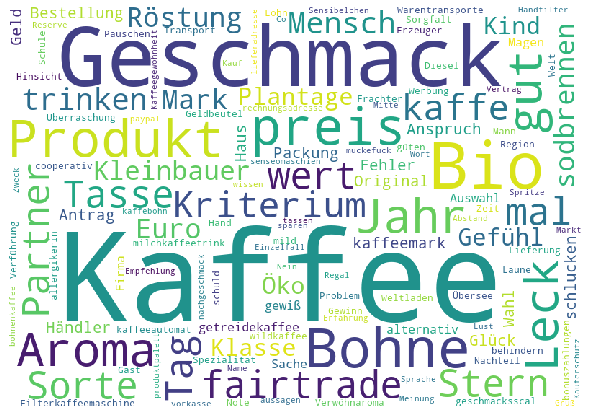

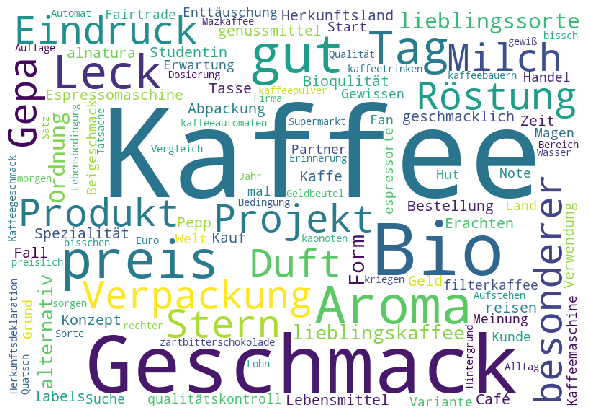

In [5]:
visualize(tm)
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)

In [40]:
clusters = [[] for _ in range(ntopic)]
for text_i, cluster in enumerate(tm.cluster_model.labels_):
    clusters[cluster].append([sentences[text_i], token_lists[text_i], meta.review[idx_in[text_i]]])

cluster_words = [np.unique(np.concatenate(np.vstack(clusters[i])[:,1]), return_counts=True) for i in range(ntopic)]
clusters = np.array(clusters)

In [73]:
def get_cluster_text(c, clusters):
    foo = []
    for l in clusters[c]:
        foo.append(l[0])
    return foo

def get_cluster_token(c, clusters):
    foo = []
    for l in clusters[c]:
        foo.append(l[1])
    return foo

def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

c = 0
threshold = 4
nouns = [x for i, x in enumerate(cluster_words[c][0]) if cluster_words[c][1][i] > threshold]
nouns_count = [x for i, x in enumerate(cluster_words[c][1]) if cluster_words[c][1][i] > threshold]

vec = tm.vectorize(nouns, get_cluster_token(c, clusters), "BERT_AE")

Getting vector representations for BERT ...
Getting vector representations for BERT. Done!


In [152]:
idx = np.argmax(nouns_count)
foo = [[euclidean_distance(vec[idx], vec[i]) for i in range(len(vec))] for idx in range(len(vec))]
bar = np.vstack([np.vstack(sorted([(i, x) for i, x in enumerate(foo[i])], key=lambda x: x[1]))[:, 0] for i in range(len(vec))])

q = queue.Queue()
q.put(idx)
used = [idx]
while not q.empty():
    idx = q.get()
    print(nouns[int(idx)])
    count = 0
    for i in bar[int(idx)][1:]:
        if i not in used:
            used.append(i)
            q.put(i)
            count += 1
        if count == 2:
            break
    print(nouns[int(used[-2])], nouns[int(used[-1])])
print(used)
#np.vstack([(i, euclidean_distance(vec[idx], vec[i])) for i in range(len(vec))])
#np.vstack(sorted(foo, key=lambda x: x[1]))[1:3][:, 0]

Kaffee
Geschmack Bio
Geschmack
Sorte Jahr
Bio
Aroma preis
Sorte
Leck Produkt
Jahr
Produkt Welt
Aroma
Produkt Welt
preis
Produkt Welt
Leck
Produkt Welt
Produkt
Produkt Welt
Welt
Produkt Welt
[4, 2.0, 1.0, 7.0, 3.0, 0.0, 9.0, 5.0, 6.0, 8.0]


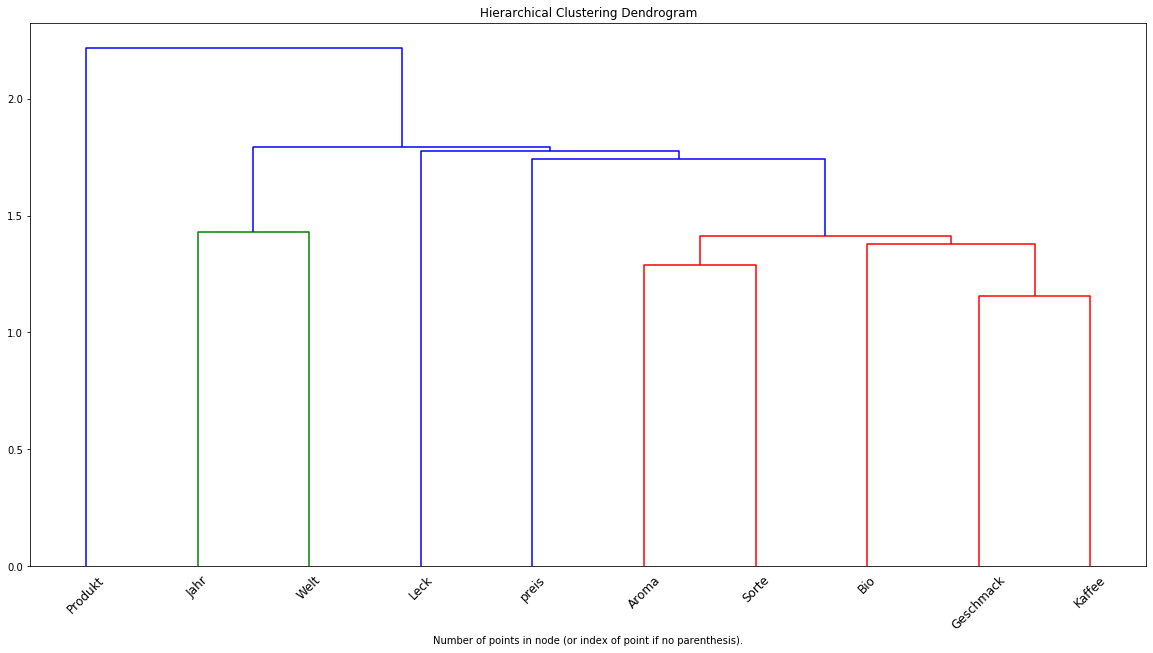

In [148]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="single").fit(vec)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p=0, labels=nouns, leaf_rotation=45)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

#plt.savefig("foo.pdf")

plt.show()

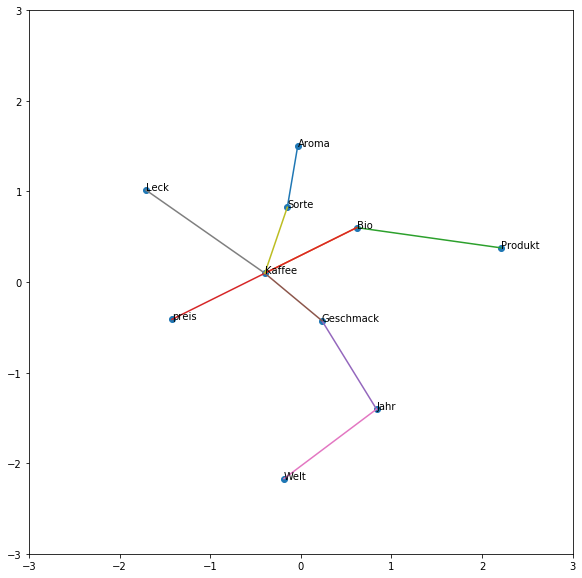

In [246]:
similarities = euclidean_distances(vec)
seed = np.random.RandomState(seed=70)
mds = manifold.MDS(n_components=2, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

plt.figure(figsize=(10,10))
plt.scatter(pos[:, 0], pos[:, 1])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal', adjustable='box')
for i, (x, y) in enumerate(pos):
    plt.annotate(nouns[i], (x, y))
for line in lines[0]:
    i, j = np.unravel_index(line, similarities.shape)
    plt.plot(pos[[i, j]][:, 0], pos[[i, j]][:, 1])

In [222]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

X = csr_matrix(np.triu(similarities))
Tcsr = minimum_spanning_tree(X)
lines = np.where(Tcsr.toarray().flatten() > 0)

In [228]:
nouns
print(similarities[7][9], similarities[1][9])

1.816517 1.7426902


In [ ]:
all_words, all_count = np.unique(np.concatenate(token_lists), return_counts=True)
entropy_words = np.empty(len(all_words))
for i, word in enumerate(all_words):
    count_per_cluster = []
    for unique, count in cluster_words:
        idx = np.where(unique == word)[0]
        if len(idx) > 0:
            count_per_cluster.append(count[idx[0]])
        else:
            count_per_cluster.append(0)
    entropy_words[i] = entropy(count_per_cluster) / np.log(len(count_per_cluster))

In [ ]:
for i in range(len(cluster_words)):
    entropy_cluster = np.empty(len(cluster_words[i][0]))
    for j, word in enumerate(cluster_words[i][0]):
        entropy_cluster[j] = entropy_words[np.where(all_words == word)[0][0]]
    cluster_words[i] = [cluster_words[i][0], cluster_words[i][1], entropy_cluster]

In [ ]:
n = 4
for words, word_count, entropy_word in cluster_words:
    #ind = np.argpartition(entropy_word, -4)[-4:]
    ind = entropy_word.argsort()[:n][::-1]
    print(words[ind])

In [ ]:
n = 4
for words, word_count, entropy_word in cluster_words:
    #ind = np.argpartition(entropy_word, -4)[-4:]
    foo = word_count / entropy_word
    ind = foo.argsort()[:n][::-1]
    print(words[ind])

In [ ]:
print(entropy_words[np.where(all_words == "Stern")[0][0]])

In [ ]:
distance_centroid = tm.cluster_model.transform(tm.vec[tm.method])

In [ ]:
sample_cluster = 8
sample_count = 3

ind = np.argsort(distance_centroid[:, sample_cluster])[::][:sample_count]
for i in ind:
    print(meta.review[idx_in[i]])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-german-cased")

In [ ]:
tokenizer.tokenize("Dachdeckerarbeiten")

In [ ]:
foo = meta.iloc[0].review

def split_sentences(doc, language="german"):
    sentences = []
    for sentence in tokenize.sent_tokenize(doc, language=language):
        sentences.append(sentence)
    return sentences

def stem(doc, lang="german"):
    tagger = ht.HanoverTagger('morphmodel_ger.pgz')
    result = []
    for sentence in doc:
        stem_sentence = tokenize.word_tokenize(sentence)
        result.append([lemma for (word, lemma, pos) in tagger.tag_sent(stem_sentence)])
    return result

def word_count(stem_sentences):
    stem_sentences = np.concatenate(stem_sentences)
    stem_sentences = stem_sentences[(stem_sentences != "--") & (stem_sentences != '“') & (stem_sentences != '„')]
    stem_sentences, counts = np.unique(stem_sentences, return_counts=True)
    return stem_sentences, counts

def frequency(word, sentence):
    unique, counts = np.unique(sentence, return_counts=True)
    index = np.where(unique == word)[0]
    if len(index) == 0:
        return 0
    return counts[index[0]] / len(sentence)

def matrix(doc):
    sentences = split_sentences(doc)
    stem_sentences = stem(sentences)
    unique_words, counts = word_count(stem_sentences)
    mat = np.empty((len(sentences), len(unique_words)))
    for i in range(len(sentences)):
        for j in range(len(unique_words)):
            if unique_words[j] in stem_sentences[i]:
                g_t_ji = 0
                for sentence in stem_sentences:
                    t_ji = frequency(unique_words[j], sentence)
                    g_ji = counts[j]
                    p_ji = t_ji / g_ji
                    if p_ji != 0:
                        g_t_ji += p_ji * np.log(p_ji) / np.log(len(sentences))
                g_t_ji = 1 - g_t_ji
                mat[i][j] = g_t_ji
            else:
                mat[i][j] = 0
    return mat

#split_sentences(foo)
#stem(split_sentences(foo))
#word_count(stem(split_sentences(foo)))
mat = matrix(foo)
u, s , vh = np.linalg.svd(mat, full_matrices=True)
vh
u
s

In [ ]:
# https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
# https://www.youtube.com/watch?v=OR0wfP2FD3c
